<a href="https://colab.research.google.com/github/muthaharnasim58/P/blob/master/Time_series_forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Forecasting using Recurrent Neural Networks**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

mpl.rcParams["figure.figsize"] = (8,6)
mpl.rcParams["axes.grid"] = False

**The Weather Dataset**

In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [0]:
df = pd.read_csv(csv_path)

Let's take a glance at the data

In [0]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 minutes. This means each hour you will 6 observatios. Similarly, a single day will contain 144 observations.

Given a specific time, lets say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5*144) observaions to train the model. 

As you can see above, an observation is recorded every 10 minutes. This means each hour you will record 6 observations. Similarly, a single day will contain 144 observations.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Let's create a training dataset with first 300000 rows of the dataset

In [0]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproductibility

In [0]:
tf.random.set_seed(13)

Let's forecast a univariate time series

In [0]:
unidata = df["T (degC)"]
unidata.index = df["Date Time"]
unidata.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

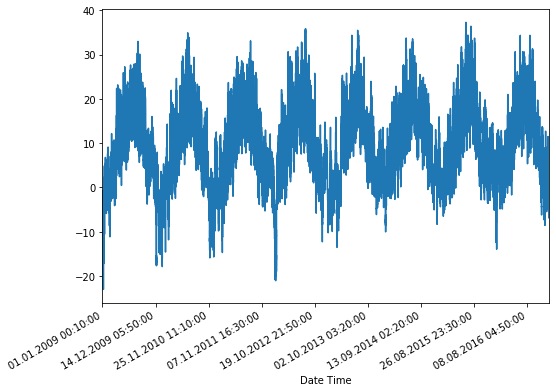

In [0]:
unidata.plot(subplots = True)
unidata = unidata.values

Let's scale features using standardization by subtracting the mean and dividing by the standard deviation of each fearures before traning a neural network

In [0]:
uni_data_mean = unidata[:TRAIN_SPLIT].mean()
uni_data_std = unidata[:TRAIN_SPLIT].std()

Lets standardized the data 

In [0]:
uni_data = (unidata-uni_data_mean)/uni_data_std

Let's now create the data for the univariate model

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(unidata, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print("Single history of past window")
print(x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single history of past window
[[-8.02]
 [-8.41]
 [-8.51]
 [-8.31]
 [-8.27]
 [-8.05]
 [-7.62]
 [-7.62]
 [-7.91]
 [-8.43]
 [-8.76]
 [-8.88]
 [-8.85]
 [-8.83]
 [-8.66]
 [-8.66]
 [-8.7 ]
 [-8.81]
 [-8.84]
 [-8.94]]

 Target temperature to predict
-8.94


Now the data has been created, lets take a look at this simple example


In [0]:
def create_time_steps(length):
  return list(range(-length,0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

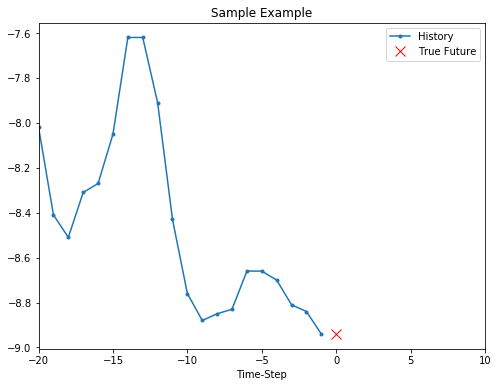

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Baseline

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

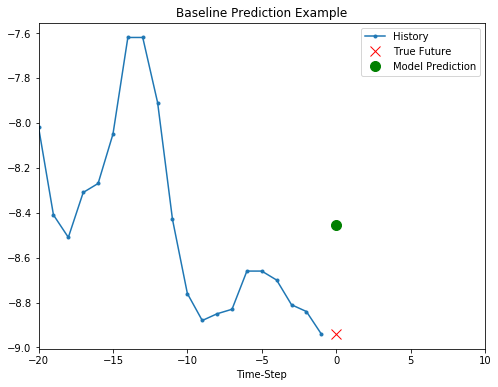

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

Recurrent Neural Network

A recurrent neural network is a type of neural network well suited for time series data. RNN processes time series step by step, maintaining an internal state summarizing the information they have seen so far. I will use a specilized rnn layer called long term short memory

In [0]:
Batch_size = 256
Buffer_size = 10000

In [0]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate = train_univariate.cache().shuffle(Buffer_size).batch(Batch_size).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(Batch_size).repeat()

LSTM 

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer = "adam", loss = "mae")

Lets make a prediction, to check the output of the model

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Forescasting a multivariate time series

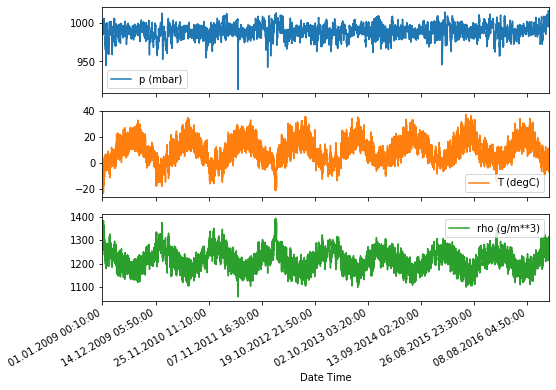

In [0]:
features_considered = ["p (mbar)", "T (degC)", 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()
features.plot(subplots = True)
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

Single Step Model

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
print("Single window of past_history:{}".format(x_train_single[0].shape))

Single window of past_history:(120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(Buffer_size).batch(Batch_size).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(Batch_size).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a simple prediction

In [0]:
for x,y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs= Epochs, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_single, validation_steps=50 )

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 27s 134ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2623 - val_loss: 0.2430
Epoch 3/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2614 - val_loss: 0.2471
Epoch 4/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2568 - val_loss: 0.2430
Epoch 5/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2262 - val_loss: 0.2364
Epoch 6/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2414 - val_loss: 0.2680
Epoch 7/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2413 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2403 - val_loss: 0.2397
Epoch 9/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2447 - val_loss: 0.2443
Epoch 10/10
200/200 [=========

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

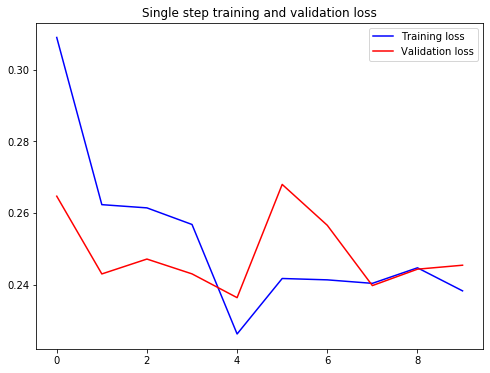

In [0]:
plot_train_history(single_step_history, 'Single step training and validation loss')

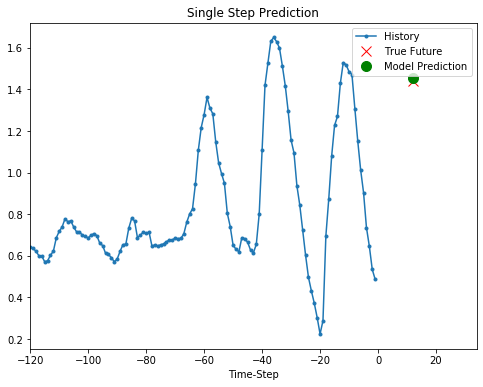

In [0]:
for x,y in val_data_single.take(1):
  plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]],12,
                   'Single Step Prediction')
  plot.show()

**Multi Step Model** 

In a multistep model, given a past history,the model needs to learn to predict a range of future values. Unlike a single step model, multi step model predict a sequence of the future. The model needs to learns to predict the temperature for next 12 hours. Since the observation is taken every 10 minutes, the output is 72 observations.

In [0]:
future_target = 72
X_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
X_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,1], TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history: (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(Buffer_size).batch(Batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((X_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(Batch_size).repeat()

Plotting a sample data point

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

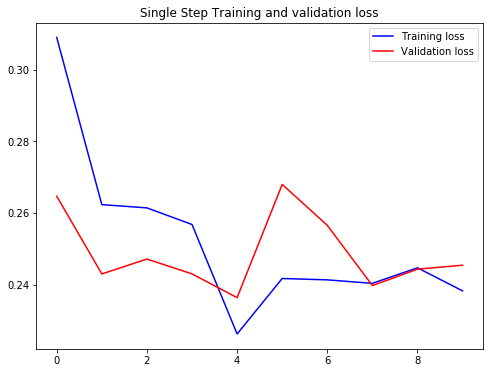

In [103]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

Predict a single step future

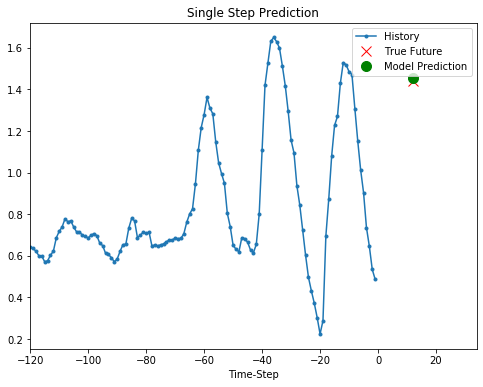

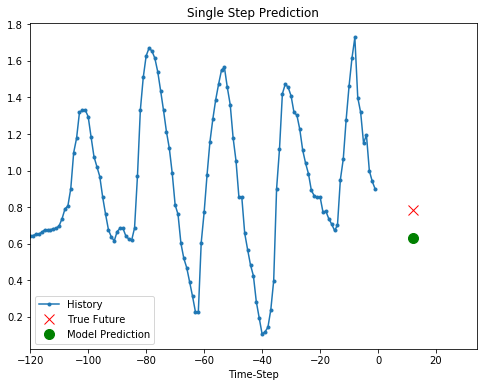

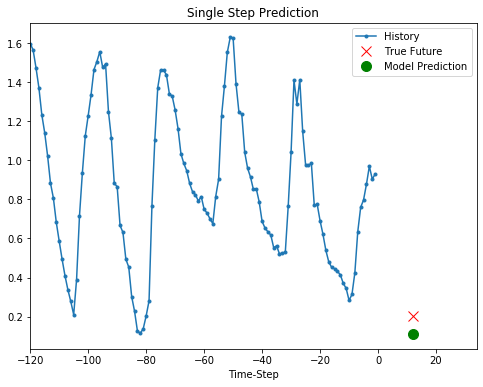

In [104]:
for x,y in val_data_single.take(3):
  plot = show_plot([x[0][:,1].numpy(),y[0].numpy(),
                    single_step_model.predict(x)[0]],12,
                   'Single Step Prediction')
  plot.show()
                    


Multi Step Model

In a multi step prediction model,the model needs to learn to predict a range of future value and unlike single step model where only a single future point is predicted, the multi step model predicts a sequence of the future

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,1], 
                                             TRAIN_SPLIT, None, past_history, 
                                             future_target, STEP)

In [111]:
print('Single window of past_history:{}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict:{}'.format(y_train_multi[0].shape))

Single window of past_history:(120, 3)

 Target temperature to predict:(72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(Buffer_size).batch(Batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(Batch_size).repeat()

Plotting a simple data point

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12,6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP,
             np.array(prediction),'ro',label = 'Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

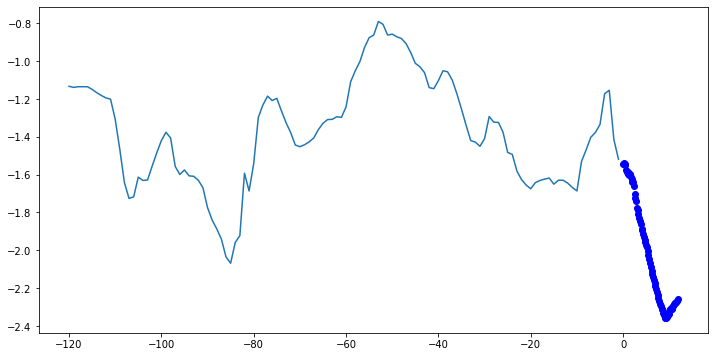

In [124]:
for x,y in train_data_multi.take(1):
  multi_step_plot(x[0],y[0], np.array([0]))


Since the model now consists of two lstm layers. Finally, since 72 predictions are made, the dense layer output 72 predictions

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


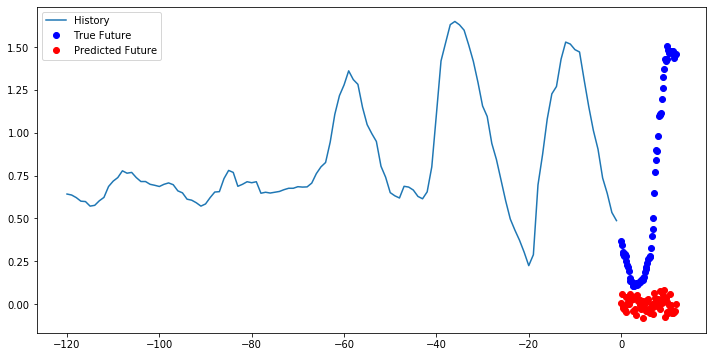

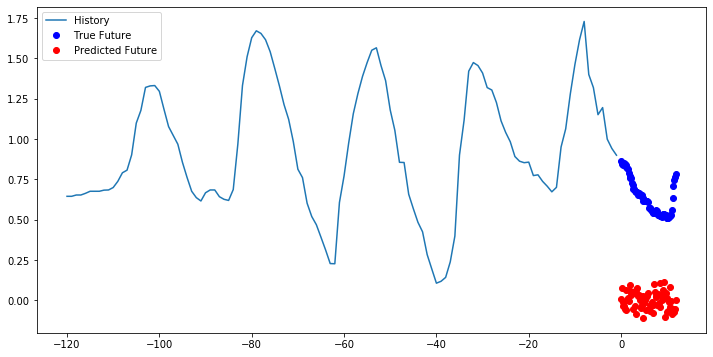

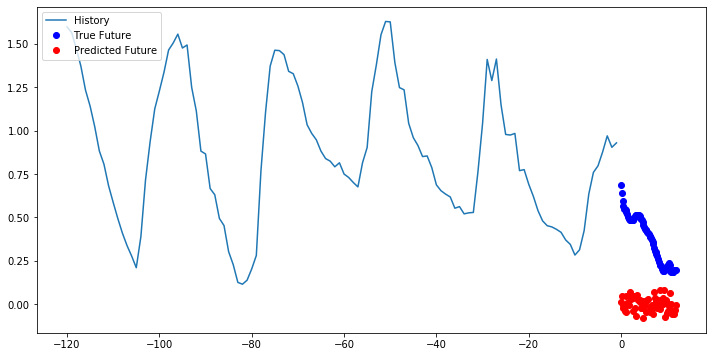

In [129]:
for x,y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [130]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=Epochs, 
                                          steps_per_epoch = EVALUATION_INTERVAL,
                                          validation_data = val_data_multi,
                                          validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 42s 211ms/step - loss: 1212.8264 - val_loss: 10.7933
Epoch 2/10
200/200 [==============================] - 39s 197ms/step - loss: 36.5270 - val_loss: 1.1832
Epoch 3/10
200/200 [==============================] - 40s 200ms/step - loss: 0.9895 - val_loss: 0.4486
Epoch 4/10
200/200 [==============================] - 40s 201ms/step - loss: 0.4300 - val_loss: 0.2865
Epoch 5/10
200/200 [==============================] - 40s 202ms/step - loss: 23.1908 - val_loss: 0.2750
Epoch 6/10
200/200 [==============================] - 40s 202ms/step - loss: 1.6337 - val_loss: 0.2813
Epoch 7/10
200/200 [==============================] - 43s 213ms/step - loss: 0.3227 - val_loss: 0.2681
Epoch 8/10
200/200 [==============================] - 43s 214ms/step - loss: 0.3095 - val_loss: 0.2592
Epoch 9/10
200/200 [==============================] - 43s 213ms/step - loss: 0.2539 - val_loss: 0.2246
Epoch 10/10
200/200 [===

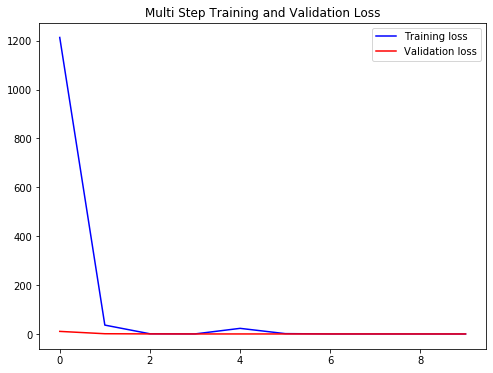

In [131]:
plot_train_history(multi_step_history, 'Multi Step Training and Validation Loss')

Predict a multistep future

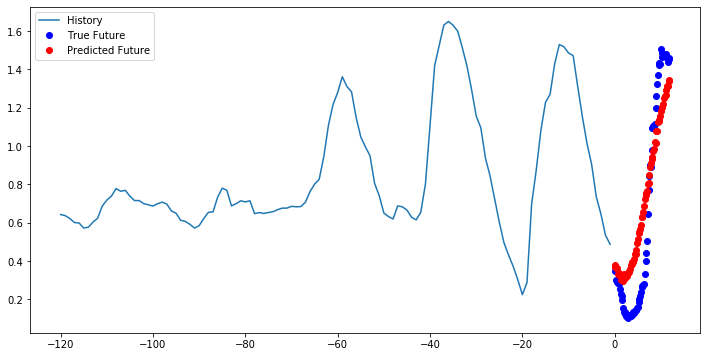

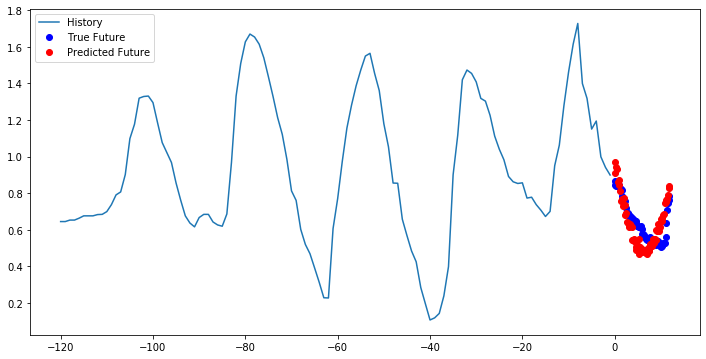

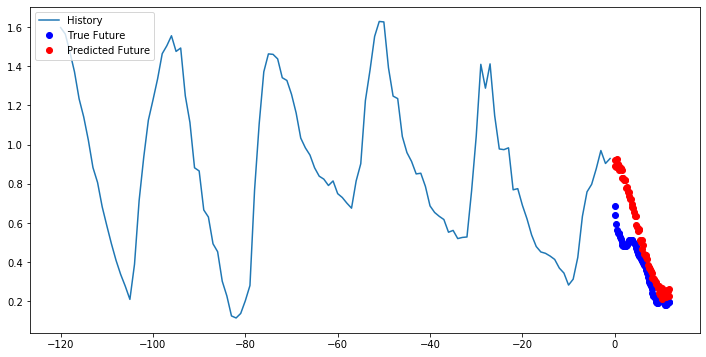

In [132]:
for x,y in val_data_multi.take(3):
  multi_step_plot(x[0],y[0], multi_step_model.predict(x)[0])